# Premier League: Results, Shots & Poisson Score Model

This notebook downloads match data for the English Premier League from **football-data.co.uk**, builds a quick EDA (league table, home/away form, shots & SOT rates), and fits a simple **Poisson model** for goals to estimate team attacking/defensive strengths and simulate match scorelines and win/draw/loss probabilities.

**Highlights**
- Auto-download CSV for a season (default: 2024–25).
- Clean league table from raw results.
- Rolling 5-match form and shots/shots-on-target (SOT) efficiency.
- Poisson model to simulate fixtures and produce match probabilities + expected table.

> For portfolio use. Data courtesy of football-data.co.uk.


In [2]:
# Setup
import io, math, textwrap
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt, requests

pd.set_option("display.max_columns", 100)
plt.rcParams["figure.figsize"] = (10, 5)

def season_code(start_year: int):
    end_year = (start_year + 1) % 100
    return f"{str(start_year)[-2:]}{end_year:02d}"

SEASON_START = 2024  # change to 2025 for 2025–26
FD_BASE = "https://www.football-data.co.uk/mmz4281"
COMP_CODE = "E0"  # Premier League
season_path = season_code(SEASON_START)
url = f"{FD_BASE}/{season_path}/{COMP_CODE}.csv"
print("Downloading:", url)

resp = requests.get(url, timeout=30)
resp.raise_for_status()
raw = resp.content
df = pd.read_csv(io.BytesIO(raw))
print("Rows:", len(df))
df.head()


Downloading: https://www.football-data.co.uk/mmz4281/2425/E0.csv
Rows: 380


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,BFH,BFD,BFA,PSH,PSD,PSA,WHH,WHD,WHA,1XBH,1XBD,1XBA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,BFEH,BFED,...,BFEAHH,BFEAHA,B365CH,B365CD,B365CA,BWCH,BWCD,BWCA,BFCH,BFCD,BFCA,PSCH,PSCD,PSCA,WHCH,WHCD,WHCA,1XBCH,1XBCD,1XBCA,MaxCH,MaxCD,MaxCA,AvgCH,AvgCD,AvgCA,BFECH,BFECD,BFECA,B365C>2.5,B365C<2.5,PC>2.5,PC<2.5,MaxC>2.5,MaxC<2.5,AvgC>2.5,AvgC<2.5,BFEC>2.5,BFEC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA,BFECAHH,BFECAHA
0,E0,16/08/2024,20:00,Man United,Fulham,1,0,H,0,0,D,R Jones,14,10,5,2,12,10,7,8,2,3,0,0,1.60,4.20,5.25,1.60,4.4,5.25,1.60,4.33,5.00,1.63,4.38,5.30,1.65,4.2,5.00,1.68,4.32,5.03,1.68,4.50,5.50,1.62,4.36,5.15,1.66,4.5,...,2.10,1.88,1.67,4.10,5.00,1.65,4.20,4.80,1.62,4.0,5.00,1.65,4.23,5.28,1.60,4.2,5.50,1.66,4.15,5.33,1.70,4.33,5.50,1.66,4.20,5.02,1.72,4.20,5.40,1.62,2.30,1.63,2.38,1.66,2.45,1.61,2.37,1.68,2.46,-0.75,1.86,2.07,1.83,2.11,1.88,2.11,1.82,2.05,1.90,2.08
1,E0,17/08/2024,12:30,Ipswich,Liverpool,0,2,A,0,0,D,T Robinson,7,18,2,5,9,18,2,10,3,1,0,0,8.50,5.50,1.33,7.50,5.5,1.36,8.50,5.50,1.33,8.18,5.84,1.34,8.50,5.5,1.33,8.60,5.85,1.35,9.00,6.10,1.37,8.28,5.76,1.34,9.40,6.2,...,2.04,1.93,8.00,5.75,1.33,8.00,5.75,1.34,7.50,5.5,1.33,8.14,6.09,1.34,8.00,5.5,1.35,8.57,5.85,1.34,8.57,6.25,1.39,7.87,5.81,1.35,8.60,6.20,1.37,1.36,3.20,1.37,3.30,1.40,3.38,1.37,3.18,1.40,3.40,1.50,2.05,1.88,2.04,1.90,2.20,2.00,1.99,1.88,2.04,1.93
2,E0,17/08/2024,15:00,Arsenal,Wolves,2,0,H,1,0,H,J Gillett,18,9,6,3,17,14,8,2,2,2,0,0,1.18,7.50,13.00,1.20,7.5,13.50,1.15,8.00,16.00,1.16,8.56,16.22,1.18,7.0,17.00,1.20,7.65,16.00,1.20,9.10,18.00,1.18,7.86,15.87,1.19,9.0,...,1.94,2.00,1.14,8.50,15.00,1.16,8.50,18.00,1.13,8.5,17.00,1.15,9.05,18.76,1.15,8.0,19.00,1.16,9.39,16.60,1.17,9.40,21.00,1.15,8.62,18.11,1.17,9.40,21.00,1.40,3.00,1.41,2.98,1.45,3.00,1.42,2.93,1.44,3.20,-2.25,2.02,1.91,2.00,1.90,2.05,1.93,1.99,1.87,2.02,1.96
3,E0,17/08/2024,15:00,Everton,Brighton,0,3,A,0,1,A,S Hooper,9,10,1,5,8,8,1,5,1,1,1,0,2.63,3.30,2.63,2.65,3.4,2.60,2.70,3.40,2.63,2.73,3.36,2.71,2.60,3.5,2.70,2.68,3.66,2.63,2.76,3.66,2.78,2.67,3.41,2.68,2.78,3.5,...,1.99,1.99,3.10,3.40,2.30,3.00,3.40,2.37,3.00,3.3,2.30,3.15,3.41,2.40,3.10,3.3,2.40,3.16,3.47,2.34,3.16,3.50,2.45,3.06,3.40,2.38,3.15,3.55,2.46,1.93,1.97,1.93,1.97,1.95,2.00,1.89,1.96,1.94,2.04,0.25,1.87,2.06,1.86,2.07,1.92,2.10,1.83,2.04,1.88,2.11
4,E0,17/08/2024,15:00,Newcastle,Southampton,1,0,H,1,0,H,C Pawson,3,19,1,4,15,16,3,12,2,4,1,0,1.36,5.25,8.00,1.35,5.5,7.75,1.33,5.50,8.50,1.35,5.70,8.25,1.35,5.5,8.00,1.37,5.74,8.10,1.37,5.90,8.60,1.35,5.62,8.10,1.37,6.0,...,1.94,2.01,1.40,5.00,7.00,1.39,5.25,7.25,1.36,5.0,7.50,1.42,5.30,7.26,1.40,5.0,7.50,1.39,5.34,7.90,1.44,5.75,8.00,1.39,5.27,7.33,1.43,5.50,8.20,1.44,2.75,1.46,2.85,1.46,3.05,1.43,2.84,1.49,2.98,-1.25,1.87,2.06,1.88,2.06,1.89,2.10,1.82,2.05,1.89,2.10


In [3]:
# Basic cleaning & column selection
wanted_cols = ["Div","Date","HomeTeam","AwayTeam","FTHG","FTAG","FTR","HS","AS","HST","AST","HTHG","HTAG","HTR"]
keep_cols = [c for c in wanted_cols if c in df.columns]
df = df[keep_cols].copy()

# Parse dates (try a few formats)
for fmt in ("%d/%m/%Y", "%d/%m/%y", "%Y-%m-%d"):
    try:
        df["Date"] = pd.to_datetime(df["Date"], format=fmt, errors="raise")
        break
    except Exception:
        continue
df = df.sort_values("Date").reset_index(drop=True)

# Keep played matches
df_played = df.dropna(subset=["FTHG","FTAG"]).copy()
df_played["FTHG"] = df_played["FTHG"].astype(int)
df_played["FTAG"] = df_played["FTAG"].astype(int)

df_played.tail(3)


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HS,AS,HST,AST,HTHG,HTAG,HTR
377,E0,2025-05-25,Bournemouth,Leicester,2,0,H,20,3,7,0,0,0,D
378,E0,2025-05-25,Liverpool,Crystal Palace,1,1,D,14,8,3,5,0,1,A
379,E0,2025-05-25,Wolves,Brentford,1,1,D,18,13,6,7,0,1,A


In [4]:
# League table
def build_table(results: pd.DataFrame) -> pd.DataFrame:
    teams = pd.unique(results[["HomeTeam","AwayTeam"]].values.ravel("K"))
    recs = []
    for t in teams:
        home = results[results["HomeTeam"] == t]
        away = results[results["AwayTeam"] == t]
        played = len(home) + len(away)
        gf = home["FTHG"].sum() + away["FTAG"].sum()
        ga = home["FTAG"].sum() + away["FTHG"].sum()
        gd = gf - ga
        pts = 0
        pts += (home["FTR"] == "H").sum() * 3 + (home["FTR"] == "D").sum() * 1
        pts += (away["FTR"] == "A").sum() * 3 + (away["FTR"] == "D").sum() * 1
        recs.append({"Team": t, "P": played, "W": None, "D": None, "L": None, "GF": gf, "GA": ga, "GD": gd, "Pts": pts})
    tab = pd.DataFrame(recs)
    w = []; d = []; l = []
    for t in tab["Team"]:
        home = results[results["HomeTeam"] == t]
        away = results[results["AwayTeam"] == t]
        w.append((home["FTR"] == "H").sum() + (away["FTR"] == "A").sum())
        d.append((home["FTR"] == "D").sum() + (away["FTR"] == "D").sum())
        l.append((home["FTR"] == "A").sum() + (away["FTR"] == "H").sum())
    tab["W"] = w; tab["D"] = d; tab["L"] = l
    tab = tab.sort_values(["Pts","GD","GF"], ascending=[False, False, False]).reset_index(drop=True)
    return tab

league_table = build_table(df_played)
league_table.head(10)


,Team,P,W,D,L,GF,GA,GD,Pts
0,Liverpool,38,25,9,4,86,41,45,84
1,Arsenal,38,20,14,4,69,34,35,74
2,Man City,38,21,8,9,72,44,28,71
3,Chelsea,38,20,9,9,64,43,21,69
4,Newcastle,38,20,6,12,68,47,21,66
5,Aston Villa,38,19,9,10,58,51,7,66
6,Nott'm Forest,38,19,8,11,58,46,12,65
7,Brighton,38,16,13,9,66,59,7,61
8,Bournemouth,38,15,11,12,58,46,12,56
9,Brentford,38,16,8,14,66,57,9,56


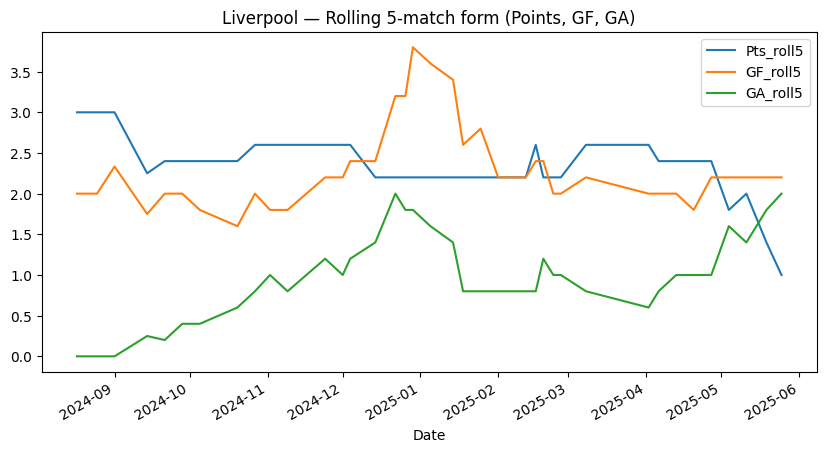

,Date,Venue,Opp,GF,GA,S,SOT,Pts,Pts_roll5,GF_roll5,GA_roll5,S_roll5,SOT_roll5
0,2024-08-17,A,Ipswich,2,0,18,5,3,3.00,2.000000,0.00,18.0,5.000000
1,2024-08-25,H,Brentford,2,0,19,8,3,3.00,2.000000,0.00,18.5,6.500000
2,2024-09-01,A,Man United,3,0,11,3,3,3.00,2.333333,0.00,16.0,5.333333
3,2024-09-14,H,Nott'm Forest,0,1,14,5,0,2.25,1.750000,0.25,15.5,5.250000
4,2024-09-21,H,Bournemouth,3,0,19,13,3,2.40,2.000000,0.20,16.2,6.800000


In [5]:
# Rolling 5-match form
def rolling_form(results: pd.DataFrame, team: str, window=5):
    rows = []
    for _, r in results.iterrows():
        if r["HomeTeam"] == team:
            pts = 3 if r["FTR"] == "H" else 1 if r["FTR"] == "D" else 0
            rows.append({"Date": r["Date"], "Venue": "H", "Opp": r["AwayTeam"],
                         "GF": r["FTHG"], "GA": r["FTAG"],
                         "S": r.get("HS", float('nan')), "SOT": r.get("HST", float('nan')),
                         "Pts": pts})
        elif r["AwayTeam"] == team:
            pts = 3 if r["FTR"] == "A" else 1 if r["FTR"] == "D" else 0
            rows.append({"Date": r["Date"], "Venue": "A", "Opp": r["HomeTeam"],
                         "GF": r["FTAG"], "GA": r["FTHG"],
                         "S": r.get("AS", float('nan')), "SOT": r.get("AST", float('nan')),
                         "Pts": pts})
    tdf = pd.DataFrame(rows).sort_values("Date").reset_index(drop=True)
    for col in ["Pts","GF","GA","S","SOT"]:
        if col in tdf:
            tdf[f"{col}_roll{window}"] = tdf[col].rolling(window, min_periods=1).mean()
    return tdf

some_team = league_table.loc[0, "Team"] if not league_table.empty else None #Selects top team
if some_team:
    tf = rolling_form(df_played, some_team, window=5)
    ax = tf.plot(x="Date", y=["Pts_roll5","GF_roll5","GA_roll5"])
    ax.set_title(f"{some_team} — Rolling 5-match form (Points, GF, GA)")
    plt.show()
tf.head()


Liverpool vs Arsenal
Expected goals: home=4.02, away=2.41
Win/Draw/Loss probabilities: 55.66% / 13.25% / 18.76%


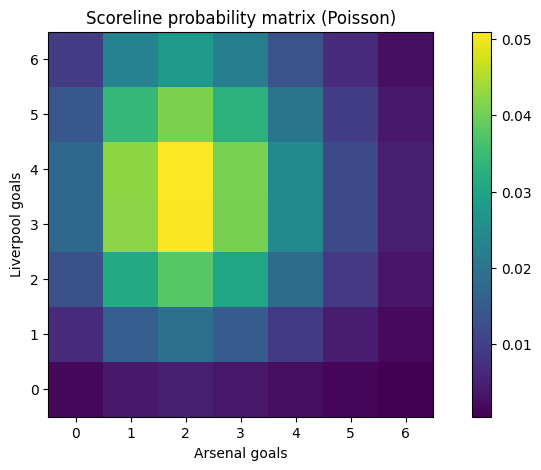

In [6]:
# Poisson model
import numpy as np, math

def team_params(results: pd.DataFrame):
    teams = pd.unique(results[["HomeTeam","AwayTeam"]].values.ravel("K"))
    home_goals = results["FTHG"].sum(); away_goals = results["FTAG"].sum(); n_games = len(results)
    mu_home = home_goals / n_games; mu_away = away_goals / n_games

    home_scored = results.groupby("HomeTeam")["FTHG"].sum()
    home_conc = results.groupby("HomeTeam")["FTAG"].sum()
    away_scored = results.groupby("AwayTeam")["FTAG"].sum()
    away_conc = results.groupby("AwayTeam")["FTHG"].sum()
    home_games = results.groupby("HomeTeam")["FTHG"].count()
    away_games = results.groupby("AwayTeam")["FTAG"].count()

    attack, defense = {}, {}
    for t in teams:
        a_home = (home_scored.get(t,0) / max(home_games.get(t,1),1)) / mu_home if mu_home > 0 else 1.0
        a_away = (away_scored.get(t,0) / max(away_games.get(t,1),1)) / mu_away if mu_away > 0 else 1.0
        attack[t] = (a_home + a_away) / 2.0

        d_home = (home_conc.get(t,0) / max(home_games.get(t,1),1)) / mu_away if mu_away > 0 else 1.0
        d_away = (away_conc.get(t,0) / max(away_games.get(t,1),1)) / mu_home if mu_home > 0 else 1.0
        defense[t] = 2.0 / ((d_home + d_away) if (d_home + d_away) > 0 else 1.0)
    return attack, defense, mu_home, mu_away

def fixture_goal_means(home, away, attack, defense, mu_home, mu_away, home_adv=1.05):
    lam_home = mu_home * attack[home] * defense[away] * home_adv
    lam_away = mu_away * attack[away] * defense[home]
    return max(lam_home, 1e-6), max(lam_away, 1e-6)

def score_matrix(lh, la, max_goals=6):
    h = np.arange(0, max_goals+1)
    a = np.arange(0, max_goals+1)
    Ph = np.exp(-lh) * (lh ** h) / np.array([math.factorial(i) for i in h])
    Pa = np.exp(-la) * (la ** a) / np.array([math.factorial(i) for i in a])
    return np.outer(Ph, Pa)

attack, defense, mu_h, mu_a = team_params(df_played)
if len(league_table) >= 2:
    home_team = league_table.loc[0, "Team"]; away_team = league_table.loc[1, "Team"]
    lam_h, lam_a = fixture_goal_means(home_team, away_team, attack, defense, mu_h, mu_a, home_adv=1.05)
    M = score_matrix(lam_h, lam_a, max_goals=6)
    p_home = np.tril(M, -1).sum(); p_draw = np.trace(M); p_away = np.triu(M, 1).sum()
    print(f"{home_team} vs {away_team}")
    print(f"Expected goals: home={lam_h:.2f}, away={lam_a:.2f}")
    print(f"Win/Draw/Loss probabilities: {p_home:.2%} / {p_draw:.2%} / {p_away:.2%}")
    fig, ax = plt.subplots()
    im = ax.imshow(M, origin="lower")
    ax.set_xlabel(f"{away_team} goals"); ax.set_ylabel(f"{home_team} goals")
    ax.set_title("Scoreline probability matrix (Poisson)"); plt.colorbar(im, ax=ax); plt.show()


In [17]:
# Monte Carlo fixture simulation
def simulate_fixture(home_team, away_team, n_sims=20000):
    lam_h, lam_a = fixture_goal_means(home_team, away_team, attack, defense, mu_h, mu_a, home_adv=1.05)
    home_scores = np.random.poisson(lam_h, size=n_sims)
    away_scores = np.random.poisson(lam_a, size=n_sims)
    return {
        "home_team": home_team, "away_team": away_team,
        "p_home": float((home_scores > away_scores).mean()),
        "p_draw": float((home_scores == away_scores).mean()),
        "p_away": float((home_scores < away_scores).mean()),
        "xg_home": float(home_scores.mean()), "xg_away": float(away_scores.mean())
    }

if len(league_table) >= 2:
    res = simulate_fixture(league_table.loc[0,"Team"], league_table.loc[1,"Team"], n_sims=10000)
    print(res)



{'home_team': 'Liverpool', 'away_team': 'Arsenal', 'p_home': 0.6641, 'p_draw': 0.1376, 'p_away': 0.1983, 'xg_home': 4.0231, 'xg_away': 2.4089}


In [10]:
print("Done. Tweak SEASON_START and re-run to switch seasons.")

Done. Tweak SEASON_START and re-run to switch seasons.
